In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.map_model import ModelConfig
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, construct_map_from_one_scan
from nf_slam.plotting_utils import show_points, plot_nf_with_scans
import matplotlib.pyplot as plt
import jax.numpy as jnp

ROS is not sourced. To enable ROS features, please source it


# Load data

In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
laser_data_list = dataset_loader.load(datafile)

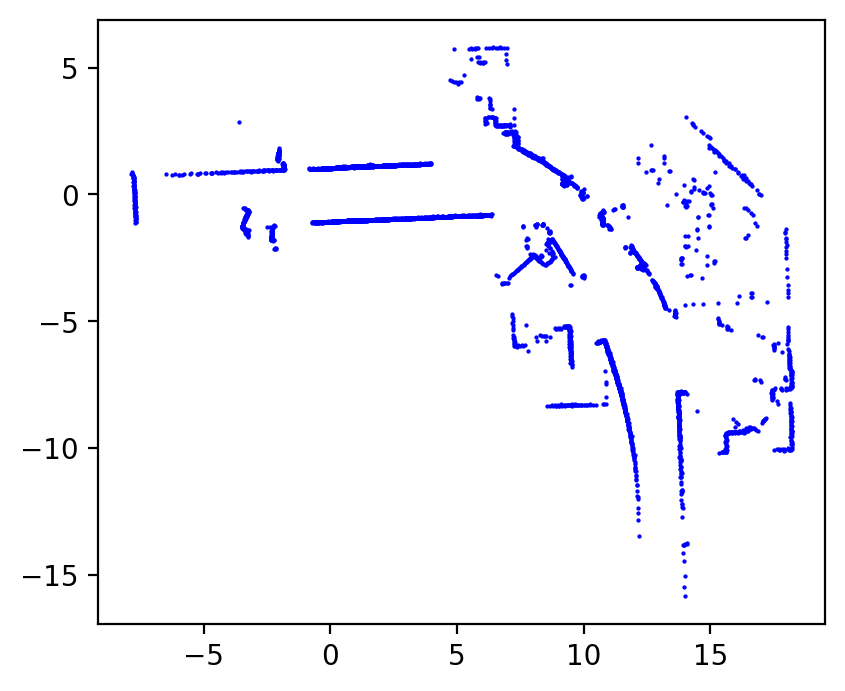

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[:30], c="blue");

# Mapping

In [5]:
model_config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.05,
    variance_weight=0.1,
    F=32,
    L=4,
    T=2048,
    min_log_resolution=-4,
    max_log_resolution=1.
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=2e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-6,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=2e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)
model = MLPModel()

learning_index = 6
laser_data = laser_data_list[learning_index]
map_position = jnp.array(laser_data.odometry_position.as_vec())
result = construct_map_from_one_scan(model_config, learning_config, laser_data, model, map_position)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.84it/s]


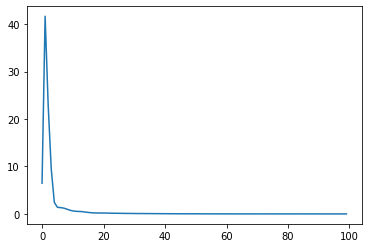

In [6]:
plt.plot(result.loss_history)

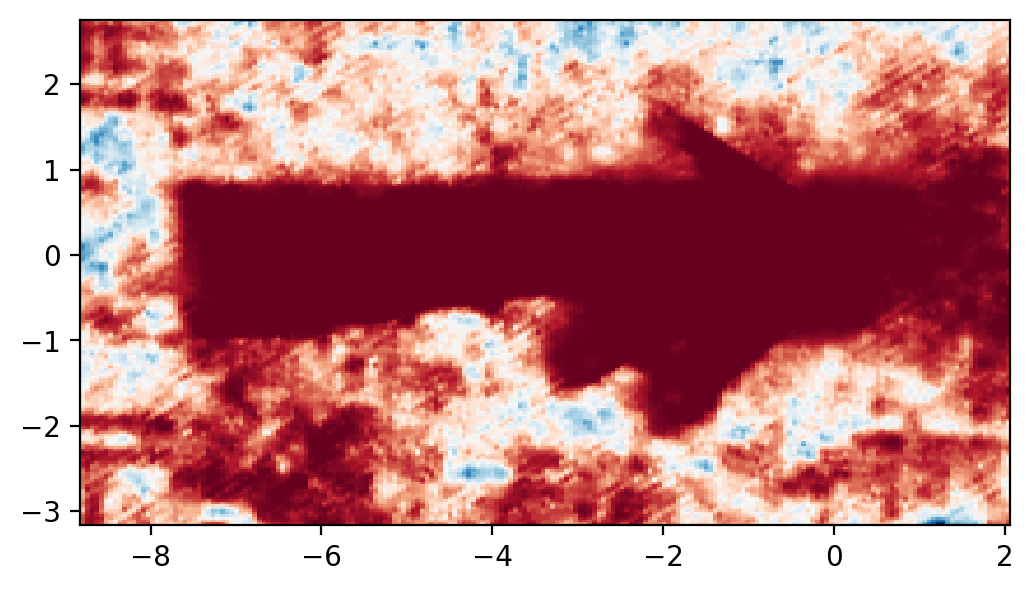

In [7]:
plt.figure(dpi=200)
plot_nf_with_scans(laser_data_list[learning_index:learning_index + 1], result.map_model, model)

In [48]:
import jax
import jax.numpy as jnp

global_list = []

def log2(x, y):
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2 + y

jitted = jax.jit(log2, static_argnums=[1,]).lower(jnp.array([3., 2]), 10).compile()
print(jax.make_jaxpr(log2, static_argnums=[1, ])(3.0, 1))


{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
    e:f32[] = add d 1.0
  in (e,) }


In [47]:
jitted(jnp.array([10., 2]))

DeviceArray([13.321928, 11.      ], dtype=float32)